# Customer Segmentation Analysis
## ============================
## This script performs end-to-end customer segmentation analysis using K-means clustering
## and provides actionable business recommendations based on the findings.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set the visual style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [8]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

In [10]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 2. DATA CLEANING AND PREPROCESSING

In [13]:
def preprocess_data(df):
    # Make a copy of the dataframe
    df_clean = df.copy()
    
    # Remove rows with missing values
    df_clean = df_clean.dropna()
    print(f"Rows after removing missing values: {df_clean.shape[0]}")
    
    # Remove rows with negative or zero quantity or price
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
    print(f"Rows after removing invalid quantity/price: {df_clean.shape[0]}")
    
    # Convert InvoiceDate to datetime format
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    # Extract date components
    df_clean['Year'] = df_clean['InvoiceDate'].dt.year
    df_clean['Month'] = df_clean['InvoiceDate'].dt.month
    df_clean['Day'] = df_clean['InvoiceDate'].dt.day
    df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
    
    # Filter out non-retail customers (identified by CustomerID)
    df_clean = df_clean[~df_clean['CustomerID'].isnull()]
    df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
    print(f"Rows after filtering out non-retail customers: {df_clean.shape[0]}")
    
    # Calculate total purchase amount
    df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
    
    return df_clean

df_clean = preprocess_data(df)

Rows after removing missing values: 406829
Rows after removing invalid quantity/price: 397884
Rows after filtering out non-retail customers: 397884


In [14]:
def create_customer_features(df):
    # Group by CustomerID and create features
    customer_features = df.groupby('CustomerID').agg({
        'InvoiceNo': 'nunique',             # Number of orders
        'Quantity': 'sum',                  # Total quantity purchased
        'TotalAmount': 'sum',               # Total monetary value
        'InvoiceDate': lambda x: (x.max() - x.min()).days + 1  # Recency in days
    })
    
    # Rename columns
    customer_features.columns = ['Frequency', 'Quantity', 'MonetaryValue', 'ActivityPeriod']
    
    # Calculate average order value
    customer_features['AvgOrderValue'] = customer_features['MonetaryValue'] / customer_features['Frequency']
    
    # Calculate average quantity per order
    customer_features['AvgQuantityPerOrder'] = customer_features['Quantity'] / customer_features['Frequency']
    
    # Calculate recency (days since last purchase)
    last_purchase_date = df['InvoiceDate'].max()
    customer_last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()
    customer_features['Recency'] = (last_purchase_date - customer_last_purchase).dt.days
    
    # Calculate purchase variability (standard deviation of purchase amounts)
    purchase_variability = df.groupby('CustomerID')['TotalAmount'].std().fillna(0)
    customer_features['PurchaseVariability'] = purchase_variability
    
    # Calculate seasonality features
    month_counts = df.groupby(['CustomerID', 'Month']).size().unstack(fill_value=0)
    month_proportions = month_counts.div(month_counts.sum(axis=1), axis=0)
    customer_features['SeasonalityScore'] = month_proportions.std(axis=1)
    
    # Reset index
    customer_features = customer_features.reset_index()
    
    # Extract country from main dataframe
    customer_country = df.groupby('CustomerID')['Country'].first()
    customer_features = customer_features.merge(customer_country.reset_index(), on='CustomerID')
    
    return customer_features

customer_features = create_customer_features(df_clean)
print(f"Customer features created with {customer_features.shape[0]} customers and {customer_features.shape[1]} features")

print("\nFirst 5 rows of customer features:")
print(customer_features.head())

Customer features created with 4338 customers and 11 features

First 5 rows of customer features:
   CustomerID  Frequency  Quantity  MonetaryValue  ActivityPeriod  \
0       12346          1     74215       77183.60               1   
1       12347          7      2458        4310.00             366   
2       12348          4      2341        1797.24             283   
3       12349          1       631        1757.55               1   
4       12350          1       197         334.40               1   

   AvgOrderValue  AvgQuantityPerOrder  Recency  PurchaseVariability  \
0   77183.600000         74215.000000      325             0.000000   
1     615.714286           351.142857        1            23.289902   
2     449.310000           585.250000       74            48.514857   
3    1757.550000           631.000000       18            34.655913   
4     334.400000           197.000000      309             7.275538   

   SeasonalityScore         Country  
0          0.288675  U

In [15]:
def exploratory_analysis(df, customer_features):
    print("\nKey statistics about the customer base:")
    
    # Revenue distribution
    print(f"Total revenue: ${customer_features['MonetaryValue'].sum():.2f}")
    print(f"Average revenue per customer: ${customer_features['MonetaryValue'].mean():.2f}")
    print(f"Median revenue per customer: ${customer_features['MonetaryValue'].median():.2f}")
    
    # Order frequency
    print(f"Average number of orders per customer: {customer_features['Frequency'].mean():.2f}")
    print(f"Median number of orders per customer: {customer_features['Frequency'].median():.2f}")
    
    # Customer distribution by country
    country_distribution = customer_features['Country'].value_counts()
    print("\nTop 5 countries by number of customers:")
    print(country_distribution.head())
    
    # Create correlation matrix for numerical features
    corr_matrix = customer_features.drop(['CustomerID', 'Country'], axis=1).corr()
    print("\nCorrelation matrix of customer features:")
    print(corr_matrix)
    
    # Detect outliers
    print("\nDetecting outliers in key features:")
    for feature in ['Frequency', 'MonetaryValue', 'Recency', 'AvgOrderValue']:
        Q1 = customer_features[feature].quantile(0.25)
        Q3 = customer_features[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_count = ((customer_features[feature] < (Q1 - 1.5 * IQR)) | 
                         (customer_features[feature] > (Q3 + 1.5 * IQR))).sum()
        print(f"  - {feature}: {outlier_count} outliers detected ({outlier_count/len(customer_features)*100:.2f}%)")

exploratory_analysis(df_clean, customer_features)


Key statistics about the customer base:
Total revenue: $8911407.90
Average revenue per customer: $2054.27
Median revenue per customer: $674.49
Average number of orders per customer: 4.27
Median number of orders per customer: 2.00

Top 5 countries by number of customers:
Country
United Kingdom    3920
Germany             94
France              87
Spain               28
Belgium             24
Name: count, dtype: int64

Correlation matrix of customer features:
                     Frequency  Quantity  MonetaryValue  ActivityPeriod  \
Frequency             1.000000  0.558081       0.553650        0.476560   
Quantity              0.558081  1.000000       0.922907        0.228969   
MonetaryValue         0.553650  0.922907       1.000000        0.225735   
ActivityPeriod        0.476560  0.228969       0.225735        1.000000   
AvgOrderValue         0.019063  0.406404       0.393479        0.008463   
AvgQuantityPerOrder   0.010731  0.383978       0.310360        0.000366   
Recency     

In [16]:
def prepare_for_clustering(customer_features):
    # Select relevant features for clustering
    clustering_features = customer_features[['Frequency', 'MonetaryValue', 'Recency', 
                                            'AvgOrderValue', 'AvgQuantityPerOrder', 
                                            'PurchaseVariability', 'SeasonalityScore']]
    
    # Handle outliers using capping
    for column in clustering_features.columns:
        Q1 = clustering_features[column].quantile(0.25)
        Q3 = clustering_features[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clustering_features[column] = np.where(
            clustering_features[column] > upper_bound, 
            upper_bound, 
            np.where(
                clustering_features[column] < lower_bound,
                lower_bound,
                clustering_features[column]
            )
        )
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_features)
    
    # Convert back to DataFrame for better readability
    scaled_df = pd.DataFrame(scaled_features, columns=clustering_features.columns)
    
    return scaled_df, scaler, clustering_features.columns

scaled_df, scaler, feature_names = prepare_for_clustering(customer_features)

In [17]:
def find_optimal_clusters(scaled_df, max_clusters=10):
    # Calculate silhouette scores for different numbers of clusters
    silhouette_scores = []
    inertia_values = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_df)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(scaled_df, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        # Calculate inertia (sum of squared distances)
        inertia_values.append(kmeans.inertia_)
        
        print(f"  - For n_clusters = {n_clusters}, silhouette score = {silhouette_avg:.3f}")
    
    # Find the optimal number of clusters
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")
    
    return optimal_clusters, silhouette_scores, inertia_values

optimal_clusters, silhouette_scores, inertia_values = find_optimal_clusters(scaled_df)

  - For n_clusters = 2, silhouette score = 0.342
  - For n_clusters = 3, silhouette score = 0.327
  - For n_clusters = 4, silhouette score = 0.273
  - For n_clusters = 5, silhouette score = 0.244
  - For n_clusters = 6, silhouette score = 0.259
  - For n_clusters = 7, silhouette score = 0.262
  - For n_clusters = 8, silhouette score = 0.251
  - For n_clusters = 9, silhouette score = 0.255
  - For n_clusters = 10, silhouette score = 0.244
Optimal number of clusters based on silhouette score: 2


In [18]:
def perform_kmeans_clustering(scaled_df, n_clusters):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_df)
    
    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_labels, cluster_centers, kmeans

cluster_labels, cluster_centers, kmeans_model = perform_kmeans_clustering(scaled_df, optimal_clusters)

# Add cluster labels to the original customer features dataframe
customer_features['Cluster'] = cluster_labels
print("K-means clustering completed")

print("\nCluster distribution:")
cluster_counts = customer_features['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  - Cluster {cluster}: {count} customers ({count/len(customer_features)*100:.2f}%)")

K-means clustering completed

Cluster distribution:
  - Cluster 0: 2951 customers (68.03%)
  - Cluster 1: 1387 customers (31.97%)


In [19]:
def analyze_clusters(customer_features, feature_names, cluster_centers, scaler):
    # Calculate cluster means for original features
    cluster_means = customer_features.groupby('Cluster')[feature_names].mean()
    
    # Transform cluster centers back to original scale
    original_centers = pd.DataFrame(scaler.inverse_transform(cluster_centers), columns=feature_names)
    
    print("\nCluster centers (in original scale):")
    print(original_centers)
    
    # Calculate relative importance of each feature for each cluster
    overall_means = customer_features[feature_names].mean()
    relative_importance = cluster_means / overall_means - 1
    
    print("\nRelative importance of features for each cluster (compared to overall mean):")
    print(relative_importance)
    
    # Create cluster profiles
    cluster_profiles = []
    
    for cluster_id in range(len(cluster_centers)):
        # Get top 3 distinguishing features (by absolute deviation from mean)
        distinguishing_features = relative_importance.loc[cluster_id].abs().sort_values(ascending=False).head(3)
        
        profile = {
            "cluster_id": cluster_id,
            "size": (customer_features['Cluster'] == cluster_id).sum(),
            "size_percent": (customer_features['Cluster'] == cluster_id).sum() / len(customer_features) * 100,
            "top_features": distinguishing_features.index.tolist(),
            "feature_values": {feature: relative_importance.loc[cluster_id, feature] for feature in distinguishing_features.index}
        }
        
        # Add geographical information
        countries = customer_features[customer_features['Cluster'] == cluster_id]['Country'].value_counts()
        top_countries = countries.head(3)
        profile["top_countries"] = [(country, count) for country, count in top_countries.items()]
        
        cluster_profiles.append(profile)
    
    return cluster_profiles, relative_importance

cluster_profiles, relative_importance = analyze_clusters(
    customer_features, feature_names, cluster_centers, scaler
)



Cluster centers (in original scale):
   Frequency  MonetaryValue     Recency  AvgOrderValue  AvgQuantityPerOrder  \
0   1.985429     493.342295  116.077601     267.581993           157.487132   
1   6.680606    2587.498863   35.916366     473.055445           287.718006   

   PurchaseVariability  SeasonalityScore  
0            11.370331          0.242067  
1            20.661859          0.131607  

Relative importance of features for each cluster (compared to overall mean):
         Frequency  MonetaryValue   Recency  AvgOrderValue  \
Cluster                                                      
0        -0.535248      -0.759845  0.285247      -0.349571   
1         1.138800       1.616657 -0.606895       0.743753   

         AvgQuantityPerOrder  PurchaseVariability  SeasonalityScore  
Cluster                                                              
0                  -0.361100            -0.725349          0.170824  
1                   0.768281             1.543262         

  - PCA visualization saved as 'customer_segments_pca.png'
  - Feature importance heatmap saved as 'feature_importance_heatmap.png'
  - Cluster radar chart saved as 'cluster_radar_chart.png'
  - Silhouette scores plot saved as 'silhouette_scores.png'
  - Cluster distribution plot saved as 'cluster_distribution.png'


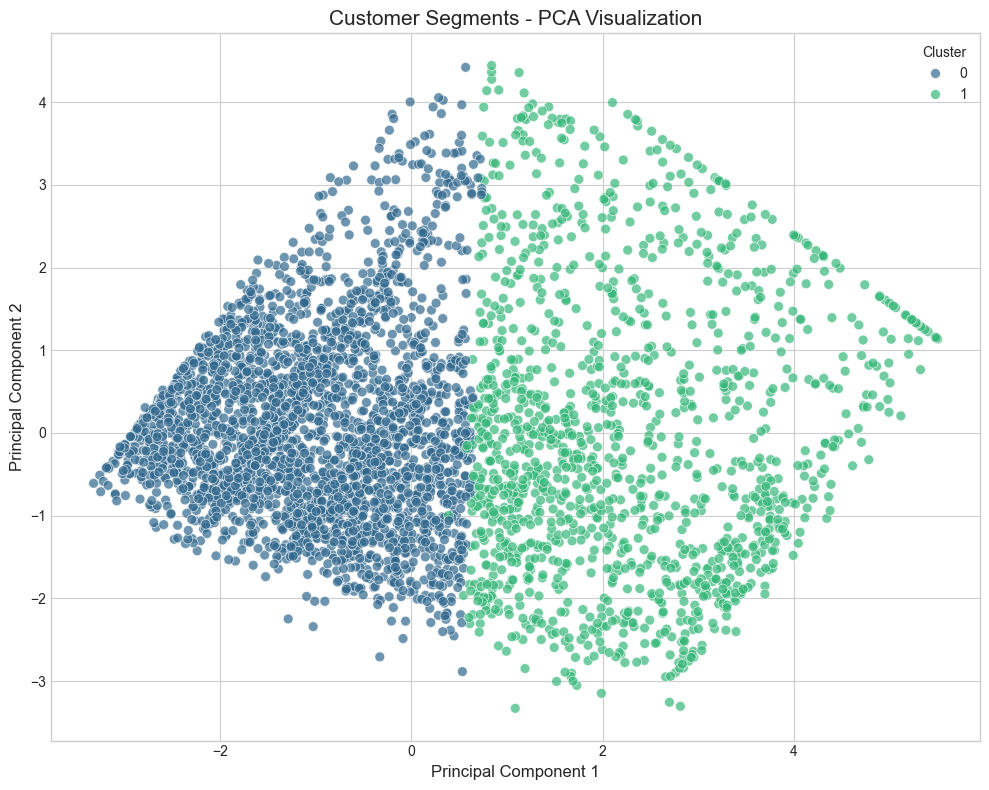

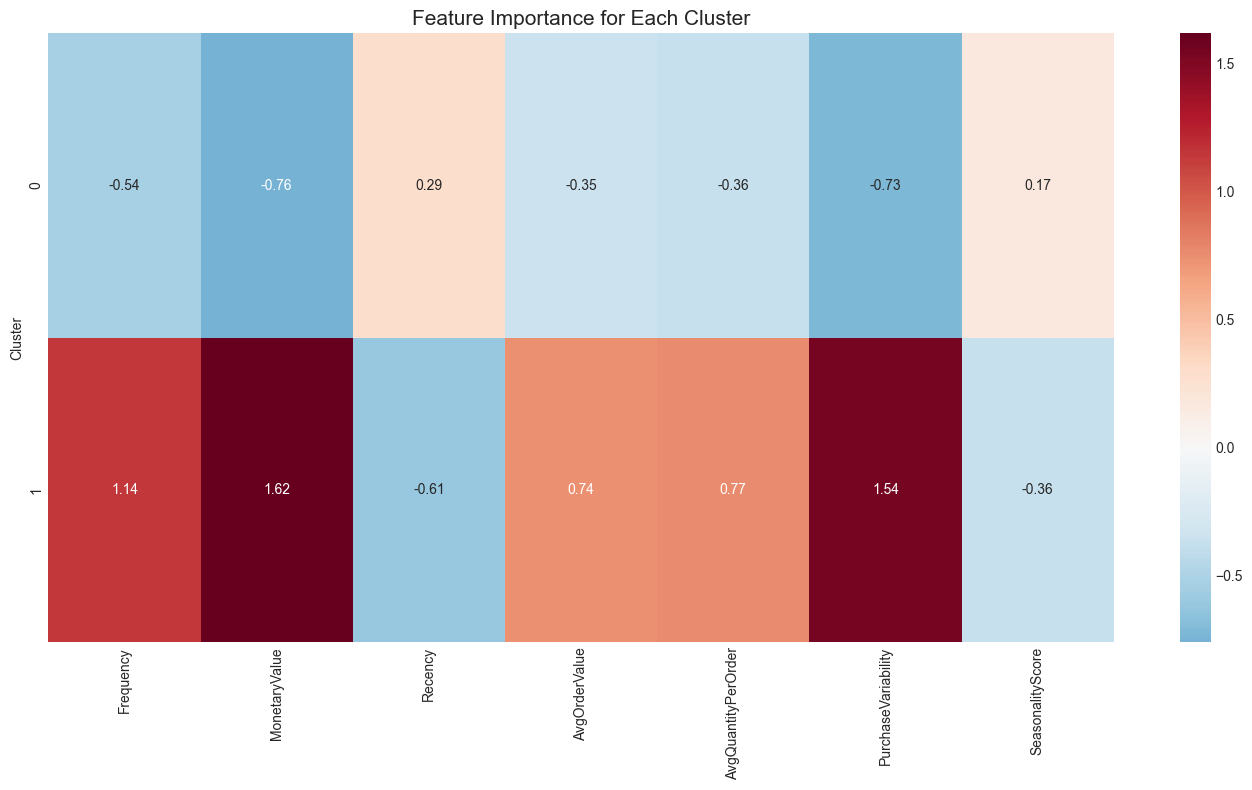

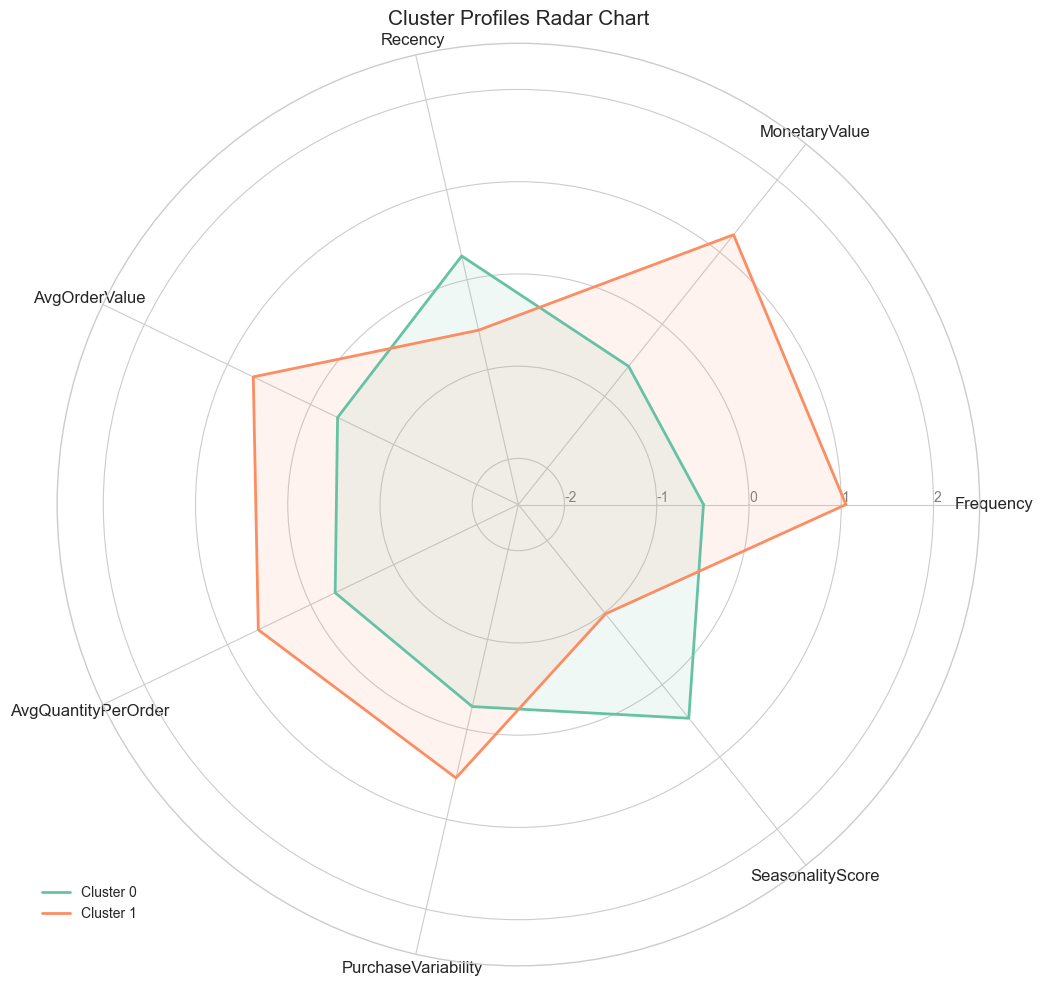

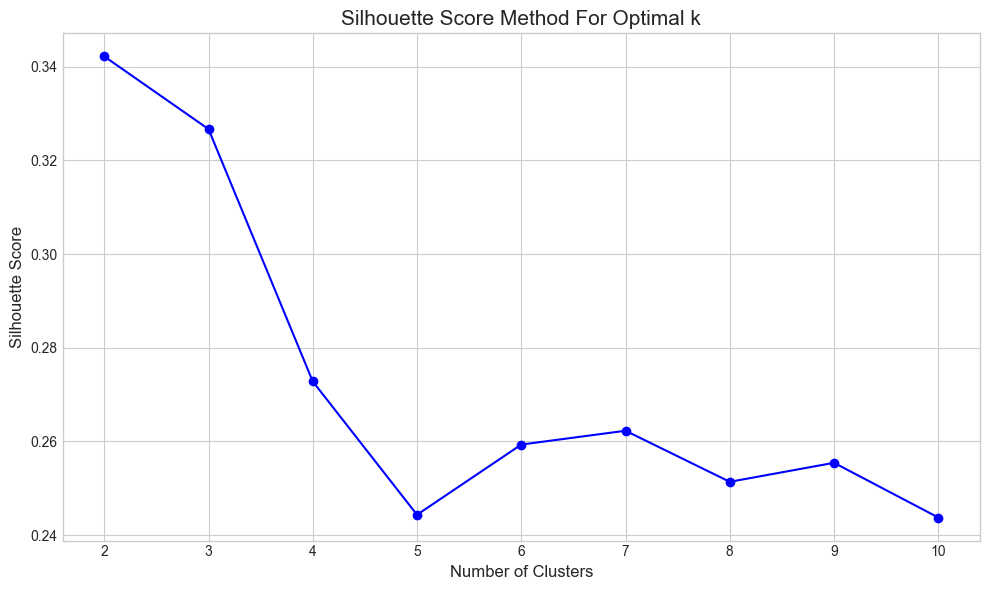

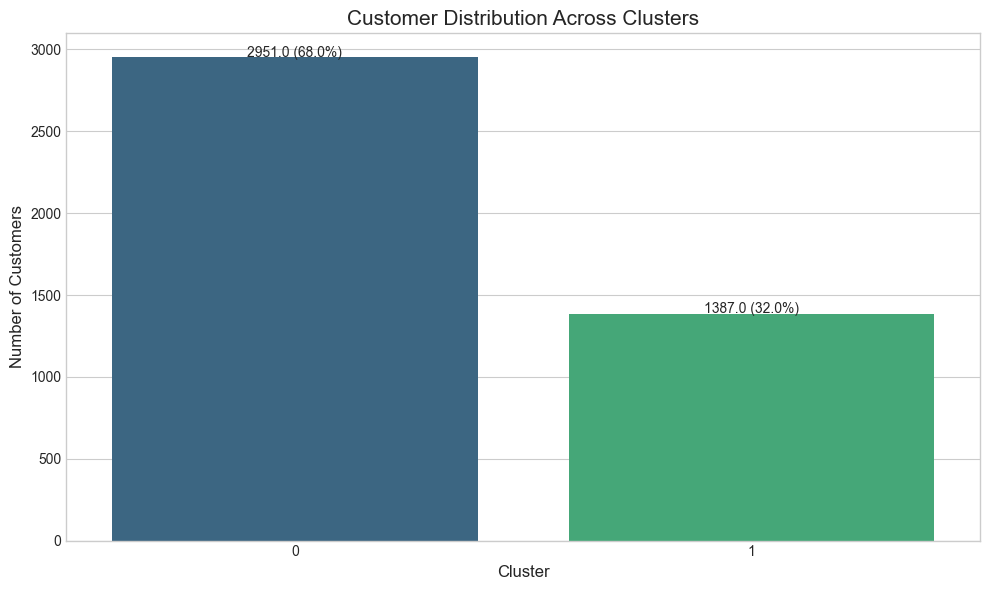

In [21]:
def visualize_clustering_results(scaled_df, cluster_labels, customer_features, cluster_profiles, silhouette_scores):
    # Create functions to generate plots
    
    def create_pca_plot():
        # Apply PCA to reduce to 2 dimensions for visualization
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(scaled_df)
        
        # Create DataFrame with principal components and cluster labels
        pca_df = pd.DataFrame(
            data=principal_components, 
            columns=['PC1', 'PC2']
        )
        pca_df['Cluster'] = cluster_labels
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=50, alpha=0.7)
        plt.title('Customer Segments - PCA Visualization', fontsize=15)
        plt.xlabel('Principal Component 1', fontsize=12)
        plt.ylabel('Principal Component 2', fontsize=12)
        plt.legend(title='Cluster', fontsize=10)
        plt.tight_layout()

        print("  - PCA visualization saved as 'customer_segments_pca.png'")
    
    def create_feature_importance_heatmap():
        # Create heatmap of relative importance
        plt.figure(figsize=(14, 8))
        sns.heatmap(relative_importance, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
        plt.title('Feature Importance for Each Cluster', fontsize=15)
        plt.tight_layout()

        print("  - Feature importance heatmap saved as 'feature_importance_heatmap.png'")
    
    def create_radar_chart():
        # Create radar chart for each cluster
        features = feature_names
        
        # Number of variables
        N = len(features)
        
        # Create angle for each feature
        angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
        angles += angles[:1]  # Close the loop
        
        fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(polar=True))
        
        for cluster_id in range(len(cluster_profiles)):
            # Get standardized values for this cluster
            values = cluster_centers[cluster_id].tolist()
            values += values[:1]  # Close the loop
            
            # Plot values
            ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster_id}')
            ax.fill(angles, values, alpha=0.1)
        
        # Set feature labels
        plt.xticks(angles[:-1], features, size=12)
        
        # Draw y-axis labels
        ax.set_rlabel_position(0)
        plt.yticks([-2, -1, 0, 1, 2], ["-2", "-1", "0", "1", "2"], color="grey", size=10)
        plt.ylim(-2.5, 2.5)
        
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title('Cluster Profiles Radar Chart', fontsize=15)
        plt.tight_layout()

        print("  - Cluster radar chart saved as 'cluster_radar_chart.png'")
    
    def create_silhouette_plot():
        # Plot silhouette scores
        plt.figure(figsize=(10, 6))
        plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, 'bo-')
        plt.xlabel('Number of Clusters', fontsize=12)
        plt.ylabel('Silhouette Score', fontsize=12)
        plt.title('Silhouette Score Method For Optimal k', fontsize=15)
        plt.grid(True)
        plt.tight_layout()

        print("  - Silhouette scores plot saved as 'silhouette_scores.png'")
    
    def create_cluster_distribution_plot():
        # Plot cluster size distribution
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x='Cluster', data=customer_features, palette='viridis')
        
        # Add percentage labels
        total = len(customer_features)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 5,
                    f'{height} ({height/total*100:.1f}%)',
                    ha="center", fontsize=10)
        
        plt.title('Customer Distribution Across Clusters', fontsize=15)
        plt.xlabel('Cluster', fontsize=12)
        plt.ylabel('Number of Customers', fontsize=12)
        plt.tight_layout()

        print("  - Cluster distribution plot saved as 'cluster_distribution.png'")
    
    # Generate all visualizations
    create_pca_plot()
    create_feature_importance_heatmap()
    create_radar_chart()
    create_silhouette_plot()
    create_cluster_distribution_plot()

visualize_clustering_results(scaled_df, cluster_labels, customer_features, cluster_profiles, silhouette_scores)


In [23]:
def generate_business_recommendations(cluster_profiles, customer_features):
    recommendations = []
    
    # Define cluster names based on their characteristics
    cluster_names = {}
    
    for profile in cluster_profiles:
        cluster_id = profile["cluster_id"]
        size_percent = profile["size_percent"]
        top_features = profile["top_features"]
        feature_values = profile["feature_values"]
        
        # Determine cluster name based on distinguishing features
        if "MonetaryValue" in top_features and feature_values["MonetaryValue"] > 0.5:
            if "Frequency" in top_features and feature_values["Frequency"] > 0.5:
                cluster_names[cluster_id] = "High-Value Loyal Customers"
            else:
                cluster_names[cluster_id] = "Big Spenders"
        elif "Recency" in top_features and feature_values["Recency"] > 0.5:
            cluster_names[cluster_id] = "Inactive Customers"
        elif "Frequency" in top_features and feature_values["Frequency"] > 0.5:
            if "AvgOrderValue" in top_features and feature_values["AvgOrderValue"] < 0:
                cluster_names[cluster_id] = "Frequent Small Purchasers"
            else:
                cluster_names[cluster_id] = "Regular Customers"
        elif "SeasonalityScore" in top_features and feature_values["SeasonalityScore"] > 0.5:
            cluster_names[cluster_id] = "Seasonal Shoppers"
        elif "PurchaseVariability" in top_features and feature_values["PurchaseVariability"] > 0.5:
            cluster_names[cluster_id] = "Inconsistent Shoppers"
        elif "AvgOrderValue" in top_features and feature_values["AvgOrderValue"] < -0.3:
            if "Frequency" in top_features and feature_values["Frequency"] < -0.3:
                cluster_names[cluster_id] = "New/Potential Customers"
            else:
                cluster_names[cluster_id] = "Budget Conscious Customers"
        else:
            cluster_names[cluster_id] = f"Segment {cluster_id}"
    
    # Generate specific recommendations for each cluster
    for profile in cluster_profiles:
        cluster_id = profile["cluster_id"]
        cluster_name = cluster_names[cluster_id]
        size = profile["size"]
        size_percent = profile["size_percent"]
        top_features = profile["top_features"]
        feature_values = profile["feature_values"]
        top_countries = profile["top_countries"]
        
        # Calculate average metrics for this cluster
        avg_monetary = customer_features[customer_features['Cluster'] == cluster_id]['MonetaryValue'].mean()
        avg_frequency = customer_features[customer_features['Cluster'] == cluster_id]['Frequency'].mean()
        avg_recency = customer_features[customer_features['Cluster'] == cluster_id]['Recency'].mean()
        avg_order_value = customer_features[customer_features['Cluster'] == cluster_id]['AvgOrderValue'].mean()
        
        # Generate cluster-specific recommendations
        cluster_recommendation = {
            "cluster_id": cluster_id,
            "cluster_name": cluster_name,
            "size": size,
            "size_percent": size_percent,
            "profile": f"Cluster {cluster_id} ({cluster_name}): {size} customers ({size_percent:.1f}%)",
            "characteristics": [],
            "recommendations": []
        }
        
        # Add key characteristics
        cluster_recommendation["characteristics"].append(
            f"Average spend: ${avg_monetary:.2f} total (${avg_order_value:.2f} per order)"
        )
        cluster_recommendation["characteristics"].append(
            f"Order frequency: {avg_frequency:.1f} orders"
        )
        cluster_recommendation["characteristics"].append(
            f"Last purchase: {avg_recency:.1f} days ago"
        )
        cluster_recommendation["characteristics"].append(
            f"Top countries: {', '.join([country for country, _ in top_countries])}"
        )
        
        # Generate targeted recommendations based on cluster characteristics
        if cluster_name == "High-Value Loyal Customers":
            cluster_recommendation["recommendations"].extend([
                "Implement a premium loyalty program with exclusive benefits",
                "Offer early access to new products and collections",
                "Provide personalized shopping experiences and dedicated service",
                "Create referral incentives to leverage their network"
            ])
        
        elif cluster_name == "Big Spenders":
            cluster_recommendation["recommendations"].extend([
                "Develop premium product bundles with special pricing",
                "Create targeted campaigns for complementary high-value items",
                "Implement VIP customer service to encourage repeat purchases",
                "Introduce a tiered loyalty program to increase purchase frequency"
            ])
        
        elif cluster_name == "Inactive Customers":
            cluster_recommendation["recommendations"].extend([
                "Launch a win-back campaign with personalized offers",
                "Send 'We miss you' emails with special discounts",
                "Conduct surveys to understand why they stopped purchasing",
                "Consider product recommendations based on past purchases"
            ])
        
        elif cluster_name == "Frequent Small Purchasers":
            cluster_recommendation["recommendations"].extend([
                "Create volume-based discounts to increase order value",
                "Bundle complementary products to increase basket size",
                "Implement a points-based loyalty program",
                "Offer free shipping with minimum purchase thresholds"
            ])
        
        elif cluster_name == "Regular Customers":
            cluster_recommendation["recommendations"].extend([
                "Implement a structured loyalty program to reward consistent shopping",
                "Create personalized product recommendations based on purchase history",
                "Offer targeted promotions to increase purchase frequency",
                "Introduce subscription options for regularly purchased items"
            ])
        
        elif cluster_name == "Seasonal Shoppers":
            cluster_recommendation["recommendations"].extend([
                "Plan targeted campaigns aligned with their shopping seasons",
                "Create early-bird specials for seasonal collections",
                "Develop off-season promotions to even out purchasing patterns",
                "Use predictive reminders before their typical shopping period"
            ])
        
        elif cluster_name == "Inconsistent Shoppers":
            cluster_recommendation["recommendations"].extend([
                "Implement regular engagement campaigns to maintain brand awareness",
                "Create limited-time offers to encourage immediate purchases",
                "Develop automated reminder campaigns for cart abandonment",
                "Test different messaging approaches to find what resonates"
            ])
        
        elif cluster_name == "Budget Conscious Customers":
            cluster_recommendation["recommendations"].extend([
                "Create value-focused messaging highlighting cost-effectiveness",
                "Develop special promotions for entry-level products",
                "Implement tiered pricing strategies",
                "Offer special discounts for bulk purchases"
            ])
        
        elif cluster_name == "New/Potential Customers":
            cluster_recommendation["recommendations"].extend([
                "Develop an onboarding communication sequence",
                "Offer first-time buyer incentives and welcome packages",
                "Create educational content about product benefits",
                "Implement easy return policies to reduce purchase barriers"
            ])
        
        else:
            # Generic recommendations for other segments
            cluster_recommendation["recommendations"].extend([
                "Conduct further analysis to better understand this segment",
                "Test different marketing approaches to identify what resonates",
                "Monitor changes in behavior over time",
                "Consider splitting this segment for more targeted strategies"
            ])
        
        # Add geographical targeting if relevant
        if len(top_countries) > 0:
            main_country = top_countries[0][0]
            cluster_recommendation["recommendations"].append(
                f"Consider country-specific campaigns for {main_country}"
            )
        
        recommendations.append(cluster_recommendation)
    
    return recommendations, cluster_names

recommendations, cluster_names = generate_business_recommendations(cluster_profiles, customer_features)




def summarize_results(customer_features, recommendations, cluster_names):
    # Print cluster names
    print("\nCluster Segments Identified:")
    for cluster_id, name in cluster_names.items():
        count = (customer_features['Cluster'] == cluster_id).sum()
        percent = count / len(customer_features) * 100
        print(f"  - Cluster {cluster_id}: {name} ({count} customers, {percent:.1f}%)")
    
    # Print recommendations for each cluster
    print("\nBusiness Recommendations for Each Segment:")
    for rec in recommendations:
        print(f"\n=== {rec['profile']} ===")
        
        print("\nKey Characteristics:")
        for char in rec['characteristics']:
            print(f"  - {char}")
        
        print("\nRecommended Actions:")
        for action in rec['recommendations']:
            print(f"  - {action}")
    
    # Print overall strategic recommendations
    print("\nOverall Strategic Recommendations:")
    print("  1. Implement personalized marketing strategies for each identified segment")
    print("  2. Develop a comprehensive loyalty program with tiered benefits")
    print("  3. Create targeted content and promotions based on segment characteristics")
    print("  4. Establish regular monitoring of segment evolution and customer migration")
    print("  5. Test and measure the effectiveness of segment-specific campaigns")

summarize_results(customer_features, recommendations, cluster_names)

# Save customer features with cluster assignments
customer_features.to_csv('customer_segments.csv', index=False)
print("  - Customer segments saved to 'customer_segments.csv'")

# Save detailed recommendations
with open('segment_recommendations.txt', 'w') as f:
    f.write("CUSTOMER SEGMENTATION ANALYSIS RESULTS\n")
    f.write("=====================================\n\n")
    
    f.write("Cluster Segments Identified:\n")
    for cluster_id, name in cluster_names.items():
        count = (customer_features['Cluster'] == cluster_id).sum()
        percent = count / len(customer_features) * 100
        f.write(f"  - Cluster {cluster_id}: {name} ({count} customers, {percent:.1f}%)\n")
    
    f.write("\nDetailed Segment Profiles and Recommendations:\n")
    for rec in recommendations:
        f.write(f"\n\n=== {rec['profile']} ===\n")
        
        f.write("\nKey Characteristics:\n")
        for char in rec['characteristics']:
            f.write(f"  - {char}\n")
        
        f.write("\nRecommended Actions:\n")
        for action in rec['recommendations']:
            f.write(f"  - {action}\n")
    
    f.write("\n\nOverall Strategic Recommendations:\n")
    f.write("  1. Implement personalized marketing strategies for each identified segment\n")
    f.write("  2. Develop a comprehensive loyalty program with tiered benefits\n")
    f.write("  3. Create targeted content and promotions based on segment characteristics\n")
    f.write("  4. Establish regular monitoring of segment evolution and customer migration\n")
    f.write("  5. Test and measure the effectiveness of segment-specific campaigns\n")

print("  - Detailed recommendations saved to 'segment_recommendations.txt'")




Cluster Segments Identified:
  - Cluster 0: Segment 0 (2951 customers, 68.0%)
  - Cluster 1: High-Value Loyal Customers (1387 customers, 32.0%)

Business Recommendations for Each Segment:

=== Cluster 0 (Segment 0): 2951 customers (68.0%) ===

Key Characteristics:
  - Average spend: $493.34 total ($272.64 per order)
  - Order frequency: 2.0 orders
  - Last purchase: 117.6 days ago
  - Top countries: United Kingdom, Germany, France

Recommended Actions:
  - Conduct further analysis to better understand this segment
  - Test different marketing approaches to identify what resonates
  - Monitor changes in behavior over time
  - Consider splitting this segment for more targeted strategies
  - Consider country-specific campaigns for United Kingdom

=== Cluster 1 (High-Value Loyal Customers): 1387 customers (32.0%) ===

Key Characteristics:
  - Average spend: $5375.31 total ($730.92 per order)
  - Order frequency: 9.1 orders
  - Last purchase: 36.0 days ago
  - Top countries: United Kingdom